In [25]:
from matplotlib import pyplot as plt
from math import floor, exp
import math
from scipy.special import expit

plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.max_open_warning': 0})

In [26]:
# %%
# will return bandwidth in Bytes/sec.
def convBandwidth(input):
    if input[-4:] == "Mbps" : return ((10**6) * float(input[:-4]))/8
    elif input[-4:] == "MBps" : return (10**6) * float(input[:-4])
    elif input[-3:] == "Bps" : return float(input[:-3])
    elif input[-3:] == "bps"    : return float(input[:-3])/8
    else:
        print("conversion not supported")
        return -1
# will return time in sec.
def convTime(input):
    if input[-2:] == "ms" : return (10**(-3) * float(input[:-2]))
    elif input[-1:] == "s" : return float(input[:-1])
    elif input[-3:] == "sec" : return float(input[:-3])
    else:
        print("conversion not supported")
        return -1

# values_dict is a time series data dictionary
def plotvstime(values_dict, xlabel, ylabel, title):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    
    plt.plot(values_dict.keys(), values_dict.values())
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
def plotlist(list_values, xlabel, ylabel, title):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    
    plt.plot(list_values)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
def plotvstime_n(values_dict_n, xlabel, ylabel, title, n_flows):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    for i in range(n_flows):
        plt.plot(values_dict_n[i].keys(), values_dict_n[i].values())
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
def plotvstime_n_avg(values_dict_n, xlabel, ylabel, title, n_flows):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    
    avg_values = {}
    for t in values_dict_n[0].keys():
        
        temp_sum = 0
        for i in range(n_flows):
            temp_sum = temp_sum + values_dict_n[i][t]
            
        avg_values[t] = temp_sum/n_flows
        #print(avg_values)
   
    plt.plot(avg_values.keys(), avg_values.values())
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.title(title)
    
def plotvstime_avg_each_flow(values_dict_n, xlabel, ylabel, title, n_flows):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    
    value_each_flow = {}
    
    for i in range(n_flows):
        value_each_flow[i+1]= sum(values_dict_n[i].values())/len(values_dict_n[i].keys())
    
    plt.bar(value_each_flow.keys(), value_each_flow.values())
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.title(title)

In [27]:

def timeToSteps(t):
    return int(t/step)

def lookback_x(t):
    t_steps = timeToSteps(t)
    return x[-t_steps] if len(x) > t_steps else x[0]

def lookback_q_delay(t):
    t_steps = timeToSteps(t)
    return q_delay[-t_steps] if len(q_delay) > t_steps else q_delay[0]


def f1():
    if round(t_pbw[-1], 3) == 0: return 0
    else: return 1

# For z < 0, returns 0 and for z > 0 , return z
def delta_check(z):
    return ((z*exp(z))/(exp(z)+1))

def signum(x):
    if ( x > 0): return 1
    elif (x < 0): return -1
    else: return 0

def q_next():
    return ((1/C)*(max(0, (x[-1]-C))) + q[-1])

def rate_q_next():
    return ((1/C)*(x[-1]-C))


def SR_2phase_pacing():
    temp = ((1.25*T)/(T+q_delay[-1]))
    return temp

def SR_2phase_cong():
    return ((2*T)/tau_min[-1])

def SR_2phase():
    return min(SR_2phase_cong(), SR_2phase_pacing()) * x[-1]

def SR_RTTprobe():
    return (tau_min[-1]/(0.4*(T+q_delay[-1]))) * ( lookback_x(T+q_delay[-1]) * (T+lookback_q_delay(T+q_delay[-1])))

def x_next():
    if mode == "probe_bwn":
        return SR_2phase()
    else:  return SR_RTTprobe()
    
    #return (1-math.exp(-k*t_prt)) * SR_RTTprobe + (1-math.exp(-k*t_pbw)) * SR_2phase

def t_pbw_next():
    return (t_pbw[-1] - 1 + (10 - t_pbw[-1] + 1)*(signum(tau_min[-1]-(T + lookback_q_delay(T)))+1)/2)

def tau_min_next():
    return (delta_check(T+lookback_q_delay(T) - tau_min[-1]) + tau_min[-1])


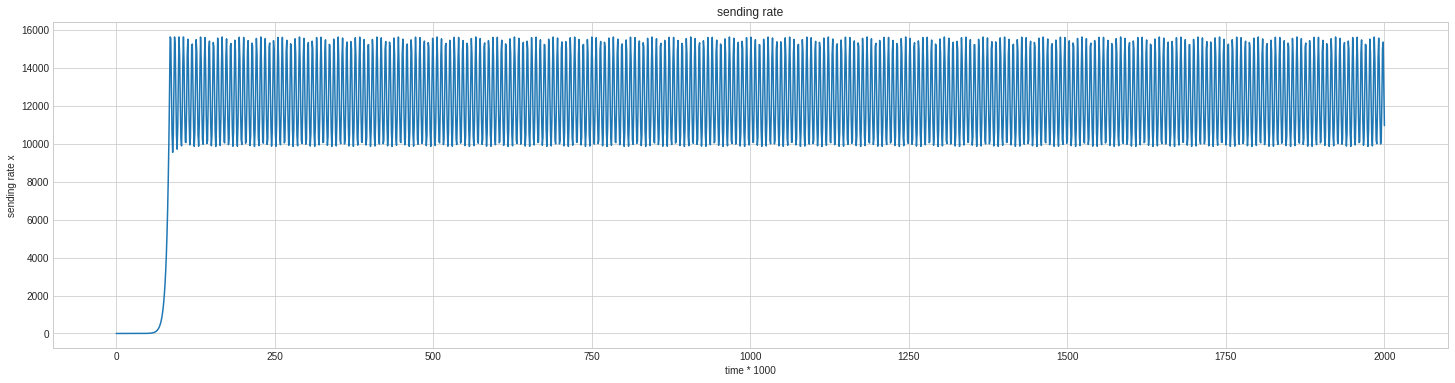

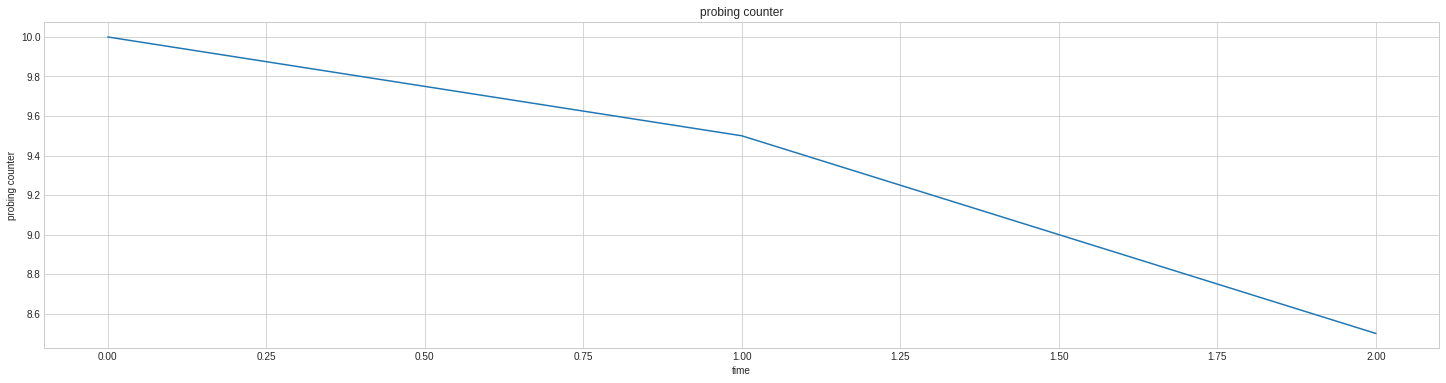

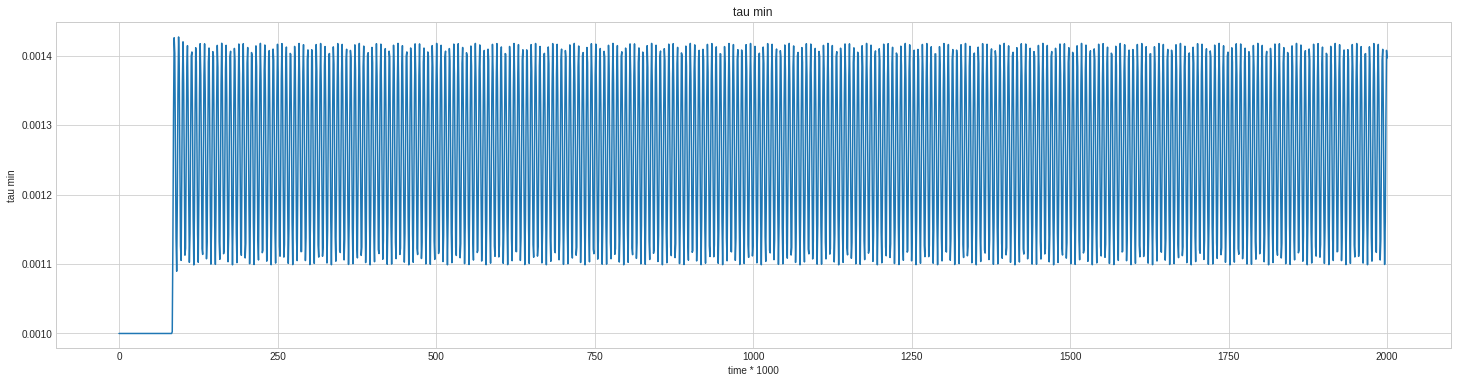

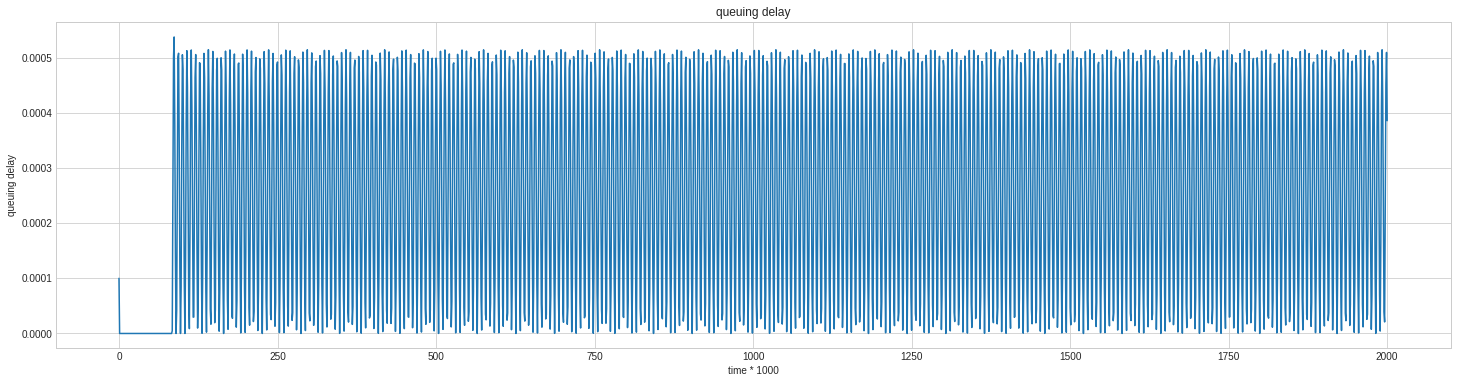

In [40]:
# CONFIG
start = 0

# needs to be smaller than the smallest value of time ( T in sec. )
step = 0.001

end = 2 / step

x = [0.0001]

t_pbw = [convTime("10sec")]
t_prt = [convTime("200ms")]
C = convBandwidth("0.1Mbps")
T = convTime("1ms")
T_steps = int(convTime("1ms") / step)
q_delay = [0.0001]
tau_min = [T]
mode = "probe_bwn"
 
t = 0
while t < end:
    
    x.append(x_next())
    
    q_delay.append(max(0, (rate_q_next()*step) + q_delay[-1]))
    
    tau_min.append(tau_min_next() )
    
    if mode == "probe_rtt":
        t_prt -= 1
        if t_prt == 0:
            mode = "probe_bwn"
            t_pbw.append(10)
            
    elif t % 1000 == 0 and mode == "probe_bwn":
            # here t_pbw goes negative, need to switch to t_prt instead for 200ms.
            t_pbw.append(t_pbw_next())
            if t_pbw[-1] == 0: 
                mode = "probe_rtt"
                t_prt = 200
                
        
    t += 1

plotlist(x, "time * " + str(int(1/step)), "sending rate x", "sending rate")

plotlist(t_pbw, "time", "probing counter", "probing counter")

plotlist(tau_min, "time * " + str(int(1/step)), "tau min", "tau min")

plotlist(q_delay, "time * " + str(int(1/step)), "queuing delay", "queuing delay")
